# Segmentation

First we read the image, the 'L' is to indicate that we want to read it in grayscale.

In [15]:
from scipy import misc
from matplotlib import pyplot as plt
image_data = misc.imread('key1.jpg', mode='L')

We can display an image with the *plt.imshow* function.

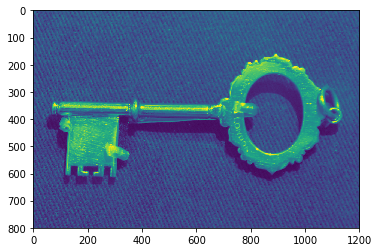

In [16]:
plt.imshow(image_data)